# Project 1 code

# Part one: Logistic Regression for Digit Classification

In [39]:
import os
import numpy as np
import pandas as pd

import warnings

import sklearn.linear_model
import sklearn.metrics
import sklearn.calibration
import sklearn.utils._testing
import sklearn.exceptions

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

# 1- Logistic Regression Model

In [56]:
# loading the dataset
x_train = np.loadtxt('./data_digits_8_vs_9_noisy/x_train.csv', delimiter = ',', skiprows=1)
x_test = np.loadtxt('./data_digits_8_vs_9_noisy/x_test.csv', delimiter = ',', skiprows=1)

y_train = np.loadtxt('./data_digits_8_vs_9_noisy/y_train.csv', delimiter = ',', skiprows=1)
y_test = np.loadtxt('./data_digits_8_vs_9_noisy/y_test.csv', delimiter = ',', skiprows=1)

### 1.1 - Iterations vs Accuracy/Log Loss

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import log_loss

acc_list = []
loss_list = []
iterations = []

@ignore_warnings(category=ConvergenceWarning)
def log_regression_accuracy(x_train, y_train, x_test, y_test):
    for i in range(1, 41, 1):
        classifier = LogisticRegression(solver='liblinear', max_iter = i)
        classifier.fit(x_train, y_train)
        y_prob_pred = classifier.predict_proba(x_train)
        accuracy = classifier.score(x_train, y_train)
        acc_list.append(accuracy)
        loss = log_loss(y_train, y_prob_pred)
        loss_list.append(loss)
        iterations.append(i)
    
    return iterations, loss_list, acc_list

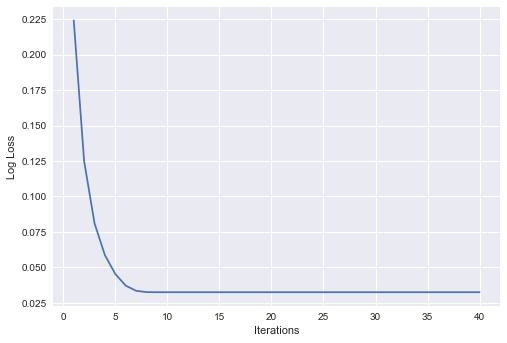

In [95]:
iterations, loss_list, acc_list = log_regression_accuracy(x_train, y_train, x_test, y_test)

plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.plot(iterations, loss_list)

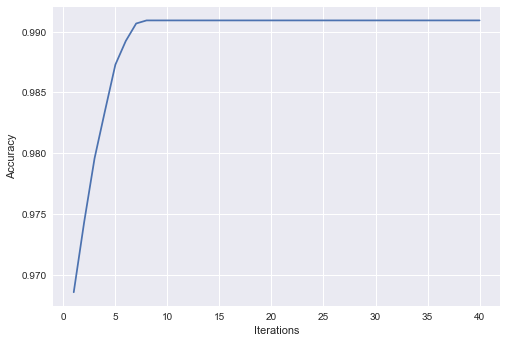

In [96]:
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(iterations, acc_list)

### 1.2 - Iterations vs Feature Weights

In [103]:
iterations = []
feature_weights = []

@ignore_warnings(category=ConvergenceWarning)
def log_regression_feature_weights(x_train, y_train, x_test, y_test):
    for i in range(1, 41, 1):
        classifier = LogisticRegression(solver='liblinear', max_iter = i)
        classifier.fit(x_train, y_train)
        
        y_prob_pred = classifier.predict_proba(x_train)
        weight = classifier.coef_[0, 0]
        feature_weights.append(weight)
        iterations.append(i)
    
    return iterations, feature_weights

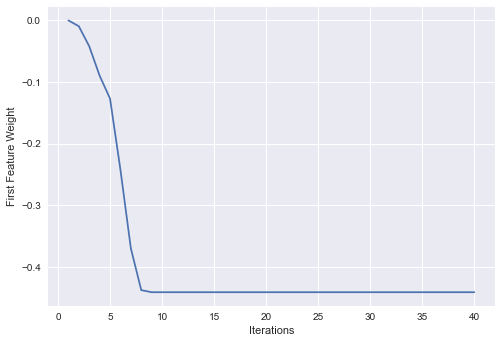

In [104]:
iterations, feature_weights = log_regression_feature_weights(x_train, y_train, x_test, y_test)

plt.xlabel('Iterations')
plt.ylabel('First Feature Weight')
plt.plot(iterations, feature_weights)

In [116]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh=0.5):
    ''' Compute the confusion matrix for a given probabilistic classifier and␣
    ↪threshold
    Args
    ----
    ytrue_N : 1D array of floats
    1
     Each entry represents the binary value (0 or 1) of 'true' label of one␣ ↪example
    One entry per example in current dataset yproba1_N : 1D array of floats
    Each entry represents a probability (between 0 and 1) that correct␣ ↪label is positive (1)
           One entry per example in current dataset
    Needs to be same size as ytrue_N thresh : float
    Scalar threshold for converting probabilities into hard decisions
    Calls an example "positive" if yproba1 >= thresh
    Default value reflects a majority-classification approach (class is the␣
    ↪one that gets
    highest probability)
    Returns
    -------
    cm_df : Pandas DataFrame
    Can be printed like print(cm_df) to easily display results '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh) 
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1]) 
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [121]:
def regularised_log_regression(x_train, y_train, x_test, y_test):
    min_loss = 1.0
    
    C_grid = np.logspace(-9, 6, 31)

    for C in C_grid:
        classifier = LogisticRegression(solver='liblinear', C=C)
        classifier.fit(x_train, y_train)
        
        y_prob_pred = classifier.predict_proba(x_test)
        loss = log_loss(y_test, y_prob_pred)
        if (loss < min_loss):
            min_loss = loss
            final_c = C
            final_acc = classifier.score(x_test, y_test)
            final_pred = classifier.predict(x_test)
    return final_c, final_acc, final_pred

value, accuracy, final_pred = regularised_log_regression(x_train, y_train, x_test, y_test)
print(value)
print(accuracy)

calc_confusion_matrix_for_threshold(y_test, final_pred)

        
    

0.03162277660168379
0.9672213817448311


Predicted,0,1
True,,
0,942,32
1,33,976


In [134]:
def find_fp_fn(prob_pred, y_test):
    fp = []
    fn = []
    
    for i in range(len(prob_pred)):
        if (prob_pred[i] == 1 and y_test[i] == 0):
            fp.append(np.asarray(x_test[i]))
        elif (prob_pred[i] == 0 and y_test[i] == 1):
            fn.append(np.asarray(x_test[i]))
    fp = fp[:9]
    fn = fn[:9]
    return fp, fn

fp, fn = find_fp_fn(final_pred, y_test)

(9, 784)

In [142]:
def reshape_arr(arr):
    array = np.zeros([28, 28])
    count  = 0
    for i in range(len(array)):
        for j in range(len(array[i])):
            element = arr[count]
            array[i][j] = element
            count+=1
    return array

def reshape_all(arr):
    ret = []
    for i in arr:
        i = reshape_arr(i)
        ret.append(i)
    return ret

fp_data = reshape_all(fp)
fn_data = reshape_all(fn)


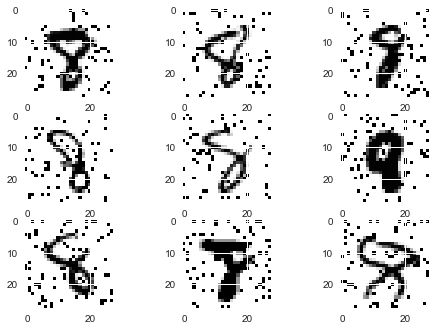

In [143]:
fig = plt.figure()
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(fp_data[0], cmap='Greys', vmin=0.0, vmax=1.0)
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(fp_data[1], cmap='Greys', vmin=0.0, vmax=1.0)
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(fp_data[2], cmap='Greys', vmin=0.0, vmax=1.0)
ax4 = fig.add_subplot(3,3,4)
ax4.imshow(fp_data[3], cmap='Greys', vmin=0.0, vmax=1.0)
ax5 = fig.add_subplot(3,3,5)
ax5.imshow(fp_data[4], cmap='Greys', vmin=0.0, vmax=1.0)
ax6 = fig.add_subplot(3,3,6)
ax6.imshow(fp_data[5], cmap='Greys', vmin=0.0, vmax=1.0)
ax7 = fig.add_subplot(3,3,7)
ax7.imshow(fp_data[6], cmap='Greys', vmin=0.0, vmax=1.0)
ax8 = fig.add_subplot(3,3,8)
ax8.imshow(fp_data[7], cmap='Greys', vmin=0.0, vmax=1.0)
ax9 = fig.add_subplot(3,3,9)
ax9.imshow(fp_data[8], cmap='Greys', vmin=0.0, vmax=1.0)

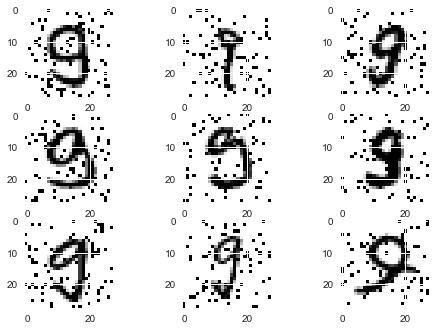

In [144]:
fig = plt.figure()
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(fn_data[0], cmap='Greys', vmin=0.0, vmax=1.0)
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(fn_data[1], cmap='Greys', vmin=0.0, vmax=1.0)
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(fn_data[2], cmap='Greys', vmin=0.0, vmax=1.0)
ax4 = fig.add_subplot(3,3,4)
ax4.imshow(fn_data[3], cmap='Greys', vmin=0.0, vmax=1.0)
ax5 = fig.add_subplot(3,3,5)
ax5.imshow(fn_data[4], cmap='Greys', vmin=0.0, vmax=1.0)
ax6 = fig.add_subplot(3,3,6)
ax6.imshow(fn_data[5], cmap='Greys', vmin=0.0, vmax=1.0)
ax7 = fig.add_subplot(3,3,7)
ax7.imshow(fn_data[6], cmap='Greys', vmin=0.0, vmax=1.0)
ax8 = fig.add_subplot(3,3,8)
ax8.imshow(fn_data[7], cmap='Greys', vmin=0.0, vmax=1.0)
ax9 = fig.add_subplot(3,3,9)
ax9.imshow(fn_data[8], cmap='Greys', vmin=0.0, vmax=1.0)

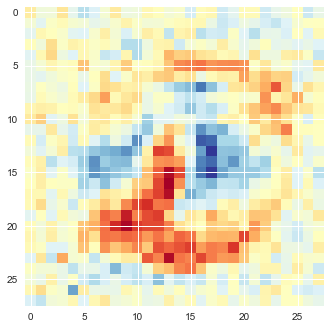

In [152]:
def get_coefficients(x_train, y_train, c_val):
    classifier = LogisticRegression(solver='liblinear', C=c_val)
    classifier.fit(x_train, y_train)
    coefficient = classifier.coef_[0]
    return coefficient

final_coeff = get_coefficients(x_train, y_train, value)

final_coeff = reshape_arr(final_coeff)

plt.imshow(final_coeff, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

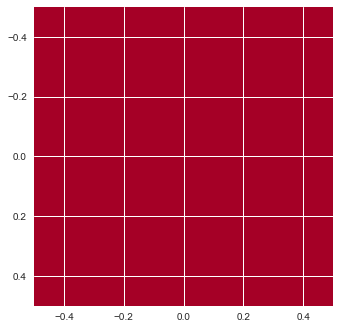

In [154]:
arr = [[-0.5]]
plt.imshow(arr, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

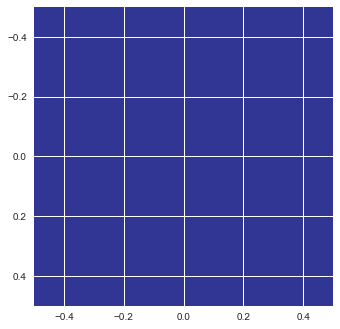

In [155]:
arr = [[0.5]]
plt.imshow(arr, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

# 2: Trousers vs Dresses

In [157]:
# loading the dataset
x_train = np.loadtxt('./data_trouser_dress/troudress_train_x.csv', delimiter = ',', skiprows=1)
x_test = np.loadtxt('./data_trouser_dress/troudress_test_x.csv', delimiter = ',', skiprows=1)

y_train = np.loadtxt('./data_trouser_dress/troudress_train_y.csv', delimiter = ',', skiprows=1)

In [193]:
def basic_log_regression(x_train, y_train, x_test):
    classifier = LogisticRegression(solver='liblinear')
    classifier.fit(x_train, y_train)
    
    yproba1_test = classifier.predict_proba(x_test)[:, 1] 
    np.savetxt('yproba1_test.txt', yproba1_test)
    
basic_log_regression(x_train, y_train, x_test)

In [232]:
def l1regularised_log_regression(x_train, y_train, x_test):
    

    classifier = LogisticRegression(solver='liblinear', penalty='l1')
    classifier.fit(x_train, y_train)
    
    yproba1_test = classifier.predict_proba(x_test)[:, 1] 
    print(yproba1_test.shape)
#     np.savetxt('yproba1_test.txt', yproba1_test)

l1regularised_log_regression(x_train, y_train, x_test)

(2000,)


In [302]:
def add_horizontal_flip_input(input_set):
    result = []
    for element in input_set:
        result.append(element)
    for element in input_set:
        new_element = np.flip(element, axis=1) 
        result.append(new_element)
    return np.array(result)

def add_horizontal_flip_output(output_set):
    result = []
    for element in output_set:
        result.append(element)
    for element in output_set:
        result.append(element)
    return np.array(result)
    
y_train_ext= add_horizontal_flip_output(y_train)

x_train_ext = np.copy(x_train)
x_train_horizontal = np.flip(x_train, axis=1)
print(np.shape(x_train_horizontal))
x_train_ext = np.append(x_train_ext, x_train_horizontal)
x_train_ext = np.reshape(x_train_ext, (24000, 784))
print(np.shape(x_train_ext))

basic_log_regression(x_train_ext, y_train_ext, x_test)

    

(12000, 784)
(24000, 784)


In [206]:
from sklearn.feature_selection import VarianceThreshold

def variance_feature_selection(x_train):
    selector = VarianceThreshold()
    x_train_new = selector.fit_transform(x_train)
    return x_train_new

x_train_updated = variance_feature_selection(x_train)
basic_log_regression(x_train_updated, y_train, x_test)
    

In [286]:
# cross validation and minimising log loss
from sklearn.model_selection import train_test_split

def cross_validation_regression(x_train, y_train, x_test):
    min_loss = 1.0
    x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(x_train, y_train, test_size=0.4, random_state=0)
    C_grid = np.logspace(-9, 6, 31)

    for C in C_grid:
        classifier = LogisticRegression(solver='liblinear', C=C)
        classifier.fit(x_train_n, y_train_n)
        
        y_prob_pred = classifier.predict_proba(x_test_n)
        loss = log_loss(y_test_n, y_prob_pred)
        if (loss < min_loss):
            min_loss = loss
            final_c = C
            final_pred = classifier.predict_proba(x_test)[:, 1]
    return final_pred, final_c
    
# prediction, c_val, y_test_n = cross_validation_regression(x_train, y_train, x_test)

# print(calc_confusion_matrix_for_threshold(y_test_n, prediction))
# print("C value is = %.3f" % c_val)

# np.savetxt('yproba1_test.txt', final_prob_pred)


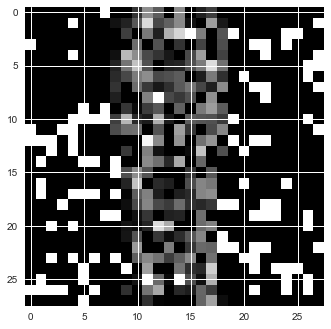

In [287]:
def plot_greymap(x_train, y_train, datapoint):
    plot = np.array(x_train[datapoint])
    plot.resize(28, 28)
    plt.imshow(plot, cmap = 'gray', vmin = 0, vmax = 1)

plot_greymap(x_train_ext, y_train_ext, 12000)

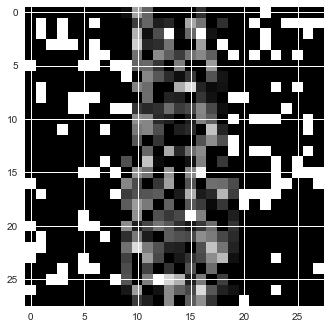

In [288]:
plot_greymap(x_train, y_train, 0)

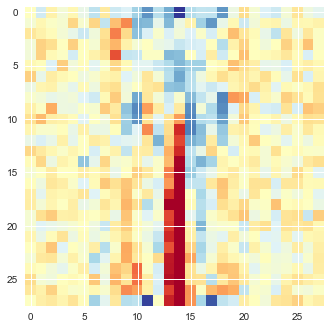

In [289]:
coefficients = get_coefficients(x_train, y_train, c_val)
coefficients.resize(28, 28)
plt.imshow(coefficients, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

In [313]:
def add_black_pixels_feature(input_set):
    black_pixels = np.zeros(len(input_set))
    for j in range(len(input_set)):
        for i in range(784):
            if (input_set[j][i] == 0.0):
                black_pixels[j] += 1
        black_train = np.hstack((input_set, np.atleast_2d(black_pixels).T))
    return black_train
def add_white_pixels_feature(input_set):
    white_pixels = np.zeros(len(input_set))
    for j in range(len(input_set)):
        for i in range(784):
            if (input_set[j][i] == 1.0):
                white_pixels[j] += 1
        white_train = np.hstack((input_set, np.atleast_2d(white_pixels).T))
    return white_train
black_pixel_count_set = add_black_pixels_feature(x_train)
bw_pixel_count_set = add_white_pixels_feature(black_pixel_count_set)

b_testset = add_black_pixels_feature(x_test)
bw_testset = add_white_pixels_feature(b_testset)

# prediction, bpixel_c = cross_validation_regression(black_pixel_count_set, y_train, x_test)


# np.savetxt('yproba1_test.txt', prediction)

In [315]:
classifier = LogisticRegression(solver='liblinear', C=0.032)
classifier.fit(bw_pixel_count_set, y_train)
        
y_prob_pred = classifier.predict_proba(bw_testset)
np.savetxt('yproba1_test.txt', prediction)